In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import torch
import torch.nn as nn
import re
from utils_notebook import histogram_experiment, dataframe_to_latex

In [5]:
results_path = "/home/elouan/code/code_repo/results/all_db_all_training/DTEC_DSIL_deterministic_exponential_s0_T400_bins7/A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02_0.02_seed_0"
# results_path = "../results/all_db_all_training/DTEC_DSIL_deterministic_exponential_s0_T400_bins7/A_synthetic_f4_s5000_c2_r0.05_0.05_seed_5"


In [6]:
max_diffusion_explanation = np.load(os.path.join(results_path, "max_diffusion_perturbation_explanation.npy"))
expected_diffusion_explanation = np.load(os.path.join(results_path, "max_diffusion_perturbation_expected_explanation.npy"))
# samples_labels = np.load(os.path.join(results_path, "samples_to_explain_labels.npy"))

In [7]:
def explanation_accuracy(ground_truth, explanation, k="auto"):
    if explanation.shape != ground_truth.shape:
        raise ValueError(
            "The explanation and ground truth must have the same shape."
        )
    if len(explanation.shape) == 1:
        explanation = explanation.reshape(1, -1)
        ground_truth = ground_truth.reshape(1, -1)
    if type(explanation) is torch.Tensor:
        explanation = explanation.cpu().detach().numpy()
    if type(ground_truth) is torch.Tensor:
        ground_truth = ground_truth.cpu().detach().numpy()
    accuracy = []
    for row in range(ground_truth.shape[0]):
        if k == "auto":
            k_ = int(np.sum(ground_truth[row]))
        else:
            k_ = k
        if k_ == 0 or int(np.sum(ground_truth[row])) == 0:
            continue
        sorted_indices = np.argsort(explanation[row])[::-1]
        instance_explanation = np.zeros_like(explanation[row])
        instance_explanation[sorted_indices[:k_]] = 1

        instance_accuracy = (
            np.sum(ground_truth[row] * instance_explanation) / k_
        )
        accuracy.append(instance_accuracy)
    return np.mean(accuracy)

In [8]:

def dcg_score_matrix_p(importance_scores, relevance_matrix, p):
    """
    Compute the DCG scores at a given cutoff rank p.
    """
    importance_scores = np.array(importance_scores)
    relevance_matrix = np.array(relevance_matrix)
    importance_scores = importance_scores.squeeze()
    relevance_matrix = relevance_matrix.squeeze()
    assert (
        importance_scores.shape == relevance_matrix.shape
    ), "importance_scores and relevance_matrix must have the same shape"

    # Sort relevance based on importance scores
    if len(importance_scores.shape) == 1:
        importance_scores = importance_scores.reshape(1, -1)
        relevance_matrix = relevance_matrix.reshape(1, -1)

    sorted_indices = np.argsort(importance_scores, axis=1)[:, ::-1]
    sorted_relevance = np.take_along_axis(
        relevance_matrix, sorted_indices, axis=1
    )

    # Consider only the top p items
    sorted_relevance_p = sorted_relevance[:, :p]
    ranks = np.arange(1, p + 1)  # Ranks from 1 to p

    # Compute DCG scores
    dcg_scores = np.sum(sorted_relevance_p / np.log2(ranks + 1), axis=1)

    return dcg_scores


def idcg_score_matrix_p(relevance_matrix, p):
    """
    Compute the IDCG scores at a given cutoff rank p.
    """
    if len(relevance_matrix.shape) == 1:
        relevance_matrix = relevance_matrix.reshape(1, -1)
    relevance_matrix = np.array(relevance_matrix)
    sorted_relevance = np.sort(relevance_matrix, axis=1)[:, ::-1]

    # Consider only the top p items
    sorted_relevance_p = sorted_relevance[:, :p]
    ranks = np.arange(1, p + 1)  # Ranks from 1 to p

    # Compute IDCG scores
    idcg_scores = np.sum(sorted_relevance_p / np.log2(ranks + 1), axis=1)

    return idcg_scores


def nDCG_(importance_scores, relevance_matrix, p):
    """
    Compute the nDCG scores at a given cutoff rank p.
    """
    dcg_scores_p = dcg_score_matrix_p(importance_scores, relevance_matrix, p)
    idcg_scores_p = idcg_score_matrix_p(relevance_matrix, p)

    # Compute normalized DCG
    ndcg_scores_p = np.zeros_like(dcg_scores_p)
    for i in range(len(dcg_scores_p)):
        if idcg_scores_p[i] == 0:
            ndcg_scores_p[i] = 0
        else:
            ndcg_scores_p[i] = dcg_scores_p[i] / idcg_scores_p[i]

    return ndcg_scores_p


def nDCG_p(importance_scores, relevance_matrix, k= 'auto'):
    nDCG_scores = []
    if len(importance_scores.shape) == 1:
        importance_scores = importance_scores.reshape(1, -1)
    if len(relevance_matrix.shape) == 1:
        relevance_matrix = relevance_matrix.reshape(1, -1)
    for i in range(importance_scores.shape[0]):
        if k == "auto":
            k_ = int(np.sum(relevance_matrix[i]))
        else:
            k_ = k
        if k_ == 0 or int(np.sum(relevance_matrix[i])) == 0:
            continue
        nDCG_scores.append(nDCG_(importance_scores[i], relevance_matrix[i], p=k_))
    return np.array(nDCG_scores)


In [13]:
K = expected_diffusion_explanation.shape[1]

In [14]:
mean_acc_k_df = pd.DataFrame(columns=["k", "mean_acc_max_diffusion", "ndcg_p"])
for k in range(1, K):
    mean_acc_k_df.loc[k-1] = {"k": k, "mean_acc_max_diffusion": explanation_accuracy(expected_diffusion_explanation, max_diffusion_explanation, k=k), "ndcg_p": np.mean(nDCG_p(max_diffusion_explanation, expected_diffusion_explanation, k=k))}
mean_acc_k_df

,k,mean_acc_max_diffusion,ndcg_p
0,1,0.795309,0.795309
1,2,0.719616,0.736745
2,3,0.675195,0.701457
3,4,0.640192,0.673502
4,5,0.623881,0.658431
5,6,0.605899,0.643077
6,7,0.584831,0.633868
7,8,0.574094,0.630250
8,9,0.562900,0.626113
9,10,0.553305,0.622151


Text(0.5, 1.0, 'Accuracy/nDCG of the explanation')

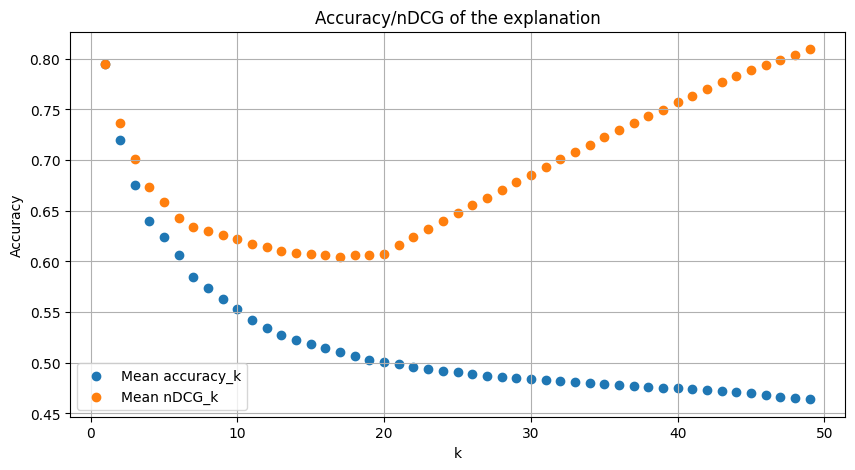

In [15]:
# Scatter plot of the accuracy of the explanation
plt.figure(figsize=(10, 5))
plt.scatter(mean_acc_k_df["k"], mean_acc_k_df["mean_acc_max_diffusion"], label="Mean accuracy_k")
plt.scatter(mean_acc_k_df["k"], mean_acc_k_df["ndcg_p"], label="Mean nDCG_k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.title("Accuracy/nDCG of the explanation")

In [16]:
expected_diffusion_explanation.shape

(500, 50)

In [17]:
expected_diffusion_explanation.sum(axis=1)

array([20., 50., 50., 17., 20., 20., 50., 20., 50., 20., 50.,  6., 20.,
       20., 17., 20.,  6., 20., 20., 20., 17., 50., 17., 50., 17., 20.,
       20., 17., 20.,  0., 20., 50., 50., 20.,  6., 17., 17., 20., 50.,
       17., 20., 20., 20., 20., 17., 20., 50., 50., 20., 17., 17.,  6.,
       50.,  6., 20., 20., 50., 17.,  6.,  6., 50., 17., 20.,  6., 50.,
        6., 50., 17., 20., 20., 50., 20., 20., 20.,  6., 50.,  6., 20.,
       20., 20., 20., 20., 20.,  0.,  6.,  6.,  6., 20., 20.,  0.,  6.,
       20., 20.,  6., 50., 50., 17.,  0., 20., 50., 20., 20., 20.,  6.,
        0.,  6., 20.,  6., 20.,  6., 20., 17., 20., 50., 50., 50., 50.,
       20., 20., 20.,  6.,  6.,  0.,  6., 50.,  6., 17., 50., 17., 50.,
       20.,  6., 20., 50.,  0.,  6., 20., 50.,  0.,  6., 20.,  6., 17.,
        6., 20., 17.,  6., 20., 20.,  6.,  0.,  0.,  6., 17., 20., 17.,
       17., 20., 20., 20., 20.,  0., 20., 20., 20.,  6., 20.,  6.,  6.,
       50., 20., 20., 20.,  6., 20., 20., 20., 20.,  6., 50., 20

In [18]:
# Take the first instance epxlanation and expected explanation
# 
instance = 15
first_explanation = max_diffusion_explanation[instance]
first_expected_explanation = expected_diffusion_explanation[instance]

print(str(first_explanation)+"\n"+ str(first_explanation.argsort()[::-1]) + "\n" + str(first_expected_explanation.astype(int)))

print()

[1.73677439e-05 8.76618420e-05 4.64853286e-05 2.59752943e-05
 2.29953552e-05 8.68843123e-06 1.96591565e-05 5.78552837e-05
 4.71966360e-05 8.21571684e-05 1.76345237e-05 3.01715310e-05
 2.32565443e-05 1.07224076e-04 7.43583703e-05 3.64651024e-05
 1.34960050e-05 1.86440321e-05 8.44578083e-05 5.29597859e-05
 2.94356804e-05 3.11974079e-05 7.71483783e-06 9.43438625e-06
 2.73828552e-05 5.09462915e-05 1.55925623e-05 9.39832063e-05
 2.60664315e-05 1.82213797e-05 1.47009808e-05 5.11849501e-05
 1.19182712e-05 8.39535955e-06 5.47705762e-06 2.61281533e-05
 4.01841715e-06 1.71237290e-05 1.44344600e-04 3.16523001e-05
 6.53548343e-05 1.67618568e-06 9.09856392e-05 2.54726055e-05
 1.19792115e-05 3.83295304e-05 3.41935799e-05 1.96928346e-05
 2.90583734e-05 1.08204971e-05]
[38 13 27 42  1 18  9 14 40  7 19 31 25  8  2 45 15 46 39 21 11 20 48 24
 35 28  3 43 12  4 47  6 17 29 10  0 37 26 30 16 44 32 49 23  5 33 22 34
 36 41]
[0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0
 1 1 0 

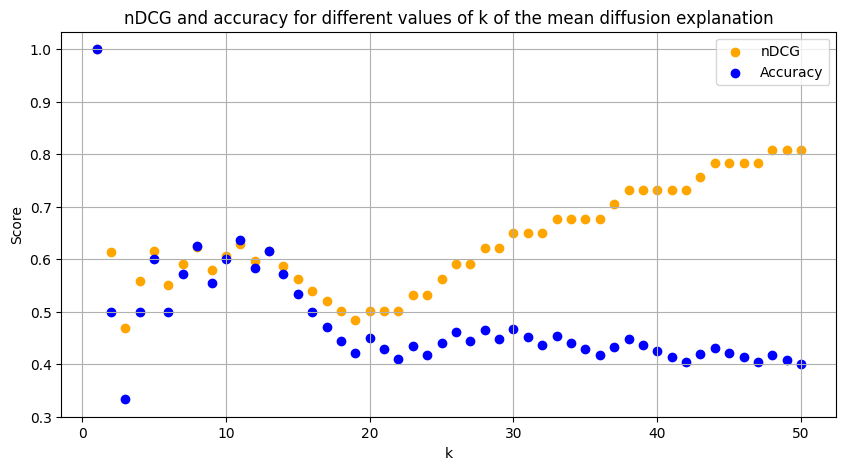

In [19]:

# Compute the nDCG score and accuracy for the first instance for different values of k and plot it
k_values = range(1, expected_diffusion_explanation.shape[1]+1)

nDCG_scores = []
accuracy_scores = []
for k in k_values:
    nDCG_scores.append(nDCG_(first_explanation, first_expected_explanation, k))
    accuracy_scores.append(explanation_accuracy(first_expected_explanation, first_explanation, k))

plt.figure(figsize=(10, 5))
plt.scatter(k_values, nDCG_scores, label="nDCG", c='orange')
plt.scatter(k_values, accuracy_scores, label="Accuracy", c='blue')
# Add horizontal line for the auto k value
plt.xlabel("k")
plt.ylabel("Score")
plt.legend()
plt.title("nDCG and accuracy for different values of k of the mean diffusion explanation")
plt.grid()


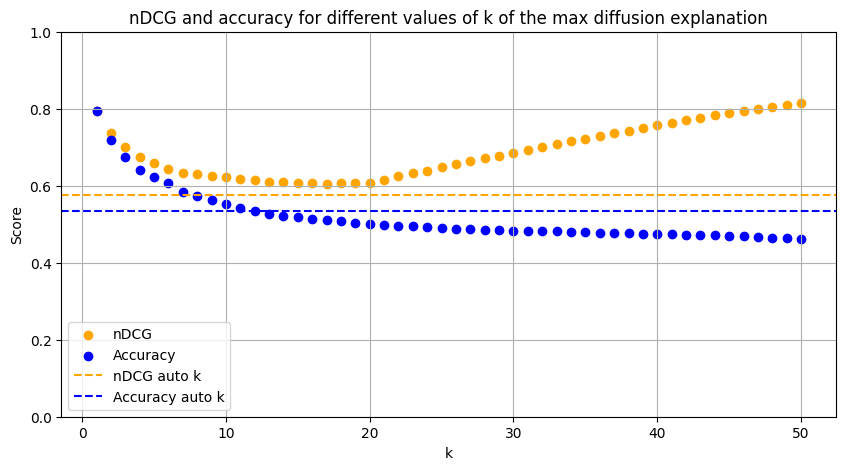

In [20]:

# Compute the nDCG score and accuracy for the first instance for different values of k and plot it


max_diffusion_nDCG_scores = []
max_diffusion_accuracy_scores = []
for k in k_values:
    max_diffusion_nDCG_scores.append(np.mean(nDCG_p(max_diffusion_explanation, expected_diffusion_explanation, k)))
    max_diffusion_accuracy_scores.append(explanation_accuracy(expected_diffusion_explanation, max_diffusion_explanation, k))
max_diffusion_auto_k_nDCG = np.mean(nDCG_p(max_diffusion_explanation, expected_diffusion_explanation, k="auto"))
max_diffusion_auto_k_accuracy = explanation_accuracy(expected_diffusion_explanation, max_diffusion_explanation, k="auto")

plt.figure(figsize=(10, 5))
plt.scatter(k_values, max_diffusion_nDCG_scores, label="nDCG", c='orange')
plt.scatter(k_values, max_diffusion_accuracy_scores, label="Accuracy", c='blue')
# Add horizontal line for the auto k value
plt.axhline(max_diffusion_auto_k_nDCG, color="orange", linestyle="--", label="nDCG auto k")
plt.axhline(max_diffusion_auto_k_accuracy, color="blue", linestyle="--", label="Accuracy auto k")
plt.xlabel("k")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.title("nDCG and accuracy for different values of k of the max diffusion explanation")
plt.grid()


In [21]:
# SHAP explanation
shap_explanation = np.load(os.path.join(results_path, "SHAP_explanation.npy"))

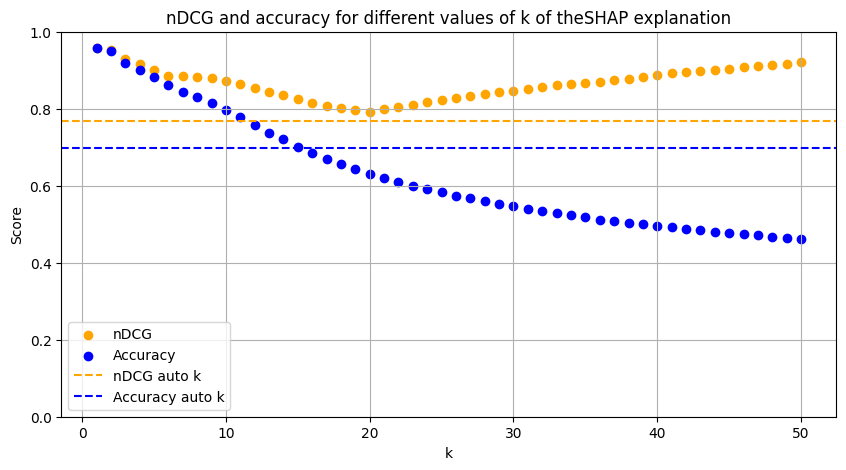

In [22]:

# Compute the nDCG score and accuracy for the first instance for different values of k and plot it


shap_nDCG_scores = []
shap_accuracy_scores = []
for k in k_values:
    shap_nDCG_scores.append(np.mean(nDCG_p(shap_explanation, expected_diffusion_explanation, k)))
    shap_accuracy_scores.append(explanation_accuracy(expected_diffusion_explanation, shap_explanation, k))
shap_auto_k_nDCG = np.mean(nDCG_p(shap_explanation, expected_diffusion_explanation, k="auto"))
shap_auto_k_accuracy = explanation_accuracy(expected_diffusion_explanation, shap_explanation, k="auto")

plt.figure(figsize=(10, 5))
plt.scatter(k_values, shap_nDCG_scores, label="nDCG", c='orange')
plt.scatter(k_values, shap_accuracy_scores, label="Accuracy", c='blue')
# Add horizontal line for the auto k value
plt.axhline(shap_auto_k_nDCG, color="orange", linestyle="--", label="nDCG auto k")
plt.axhline(shap_auto_k_accuracy, color="blue", linestyle="--", label="Accuracy auto k")
plt.xlabel("k")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.title("nDCG and accuracy for different values of k of theSHAP explanation")
plt.grid()


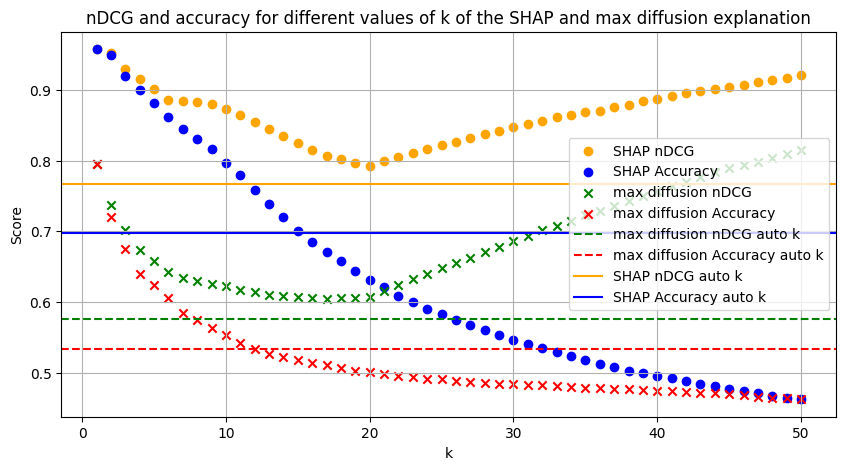

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(k_values, shap_nDCG_scores, label="SHAP nDCG", c='orange', marker='o')
plt.scatter(k_values, shap_accuracy_scores, label="SHAP Accuracy", c='blue', marker='o')
plt.scatter(k_values, max_diffusion_nDCG_scores, label="max diffusion nDCG", c='green', marker='x')
plt.scatter(k_values, max_diffusion_accuracy_scores, label="max diffusion Accuracy", c='red', marker='x')
# Add horizontal line for the auto k value
plt.axhline(max_diffusion_auto_k_nDCG, color="green", linestyle="--", label="max diffusion nDCG auto k")
plt.axhline(max_diffusion_auto_k_accuracy, color="red", linestyle="--", label="max diffusion Accuracy auto k")

plt.axhline(shap_auto_k_nDCG, color="orange", linestyle="-", label="SHAP nDCG auto k")
plt.axhline(shap_auto_k_accuracy, color="blue", linestyle="-", label="SHAP Accuracy auto k")
plt.xlabel("k")
plt.ylabel("Score")
plt.legend()
plt.title("nDCG and accuracy for different values of k of the SHAP and max diffusion explanation")
plt.grid()